# Multi-Objective Optimization of Heat Exchangers

## Importing the modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import CoolProp.CoolProp as Cool
from scipy import integrate
from scipy import interpolate
from scipy.optimize import curve_fit
from scipy.optimize import fsolve

from pymoo.util.misc import stack
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2

from pymoo.factory import get_sampling, get_crossover, get_mutation
from pymoo.factory import get_termination
from pymoo.util.termination.f_tol import MultiObjectiveSpaceToleranceTermination
from pymoo.factory import get_sampling, get_crossover, get_mutation
from pymoo.operators.mixed_variable_operator import MixedVariableSampling, MixedVariableMutation, MixedVariableCrossover
from pymoo.optimize import minimize

In [51]:
plt.rc('font',family = 'serif',size = 12)
plt.rc('text', usetex = True)

## Calculating the Properties of the Fluid

In [2]:
def Prop_Fluid(Temp, fluid ='Water'):
    
    """
    rho, cp, mu, Pr, k = Prop_Fluid(Temp,fluid)
    
    Function to calculate the density, specific heat, viscosity, Prandtl number and thermal conductivity of a determined fluid
    
    #Inputs:
    - Temp: Temperature of the fluid [ºC]
    - fluid: name of the fluid [-]
    
    # Outputs
    - rho: Density of the fluid [kg/m3] 
    - cp: Specific Heat of the fluid [kJ/kg.K]
    - mu: Viscosiity off the fluid [Pa.s]
    - Pr:  Prandtl numbber of the fluid [-] 
    - k: Thermal conductiviity of the fluid [W/(m2.K)]
    

    """
    
    rho = Cool.PropsSI('D','T',273.15 + Temp ,'P',101325, fluid)       # [kg/m3] Density
    cp  = Cool.PropsSI('C','T',273.15 + Temp ,'P',101325, fluid)       # [kJ/kg.K] Specific heat
    mu = Cool.PropsSI('V','T',273.15 + Temp ,'P',101325, fluid)        # [Pa.s] Viscosity
    Pr = Cool.PropsSI('PRANDTL','T',273.15 + Temp,'P',101325, fluid)   # [-] Prandtl Number
    k = Cool.PropsSI('L','T',273.15+Temp,'P',101325, fluid)            # [W/(m2.K)] Thermal Conductivity
    
    return rho, cp, mu,Pr, k

## Regression of the fan curve

In [3]:
def fan(V,a,b,c):
    """
    Arbitrary funtion to do the fan regression
    """
    
    P = a*V**2+b*V + c
    return P

#### Fan Data 

In [4]:
dP_fan = np.array([0,20,40,60])
V_fan = np.array([3540,3245,2895,2480])/3600
eta_fan = (dP_fan*V_fan)/np.array([183,189,194,200])

Coef_fan = curve_fit(fan,V_fan,dP_fan,maxfev=10000)
Coef_eta = curve_fit(fan,V_fan,eta_fan,maxfev=10000)

## Input Parameters

In [5]:
# Properties of the Air

rho_a, cp_a, mu_a,Pr_a, k_a = Prop_Fluid(28, 'Air')

#Properties of the metals

k_w = 273       # Thermal Conductivity of Aluminum
rho_al = 2700   # Density of Aluminum
rho_cu = 9000   # Density of Copper

#Geometric characteritics of the Heat Exchanger
p_d = 0.0018
sigmah = 0.00030 
sigmaf = 0.15*10**-3
xf = 7*10**-3

## Calculation of the Characteristic Areas

In [6]:
def HT_Area(Xl, Xt, De,sigmaf, theta, Beta, L1, L2, L3, N_t):
    
    """
    A_s, A_t, A_fr, A_min_o, sigma, D_h = HT_Area(Xl, Xt, De,sigmaf, theta, Beta, L1, L2, L3, N_t)
    
    Returns the main heat transfer area for the Heat Exchanger:
    
    Inputs:
    - Xl: Longitudinal Pitch [m] 
    - Xt: Transversal Pitch [m]
    - De: External tube diameter [m]
    - sigmaf: Thickness of the fin [m]
    - theta: fin inclination [-]
    - Beta: Fin density [1/m]
    - L1: Length of the Heat Exchanger [m]
    - L2: Width of the Heat Exchanger [m]
    - L3: Height of the Heat Exchanger Circuit [m]
    - N_t: Number of Tubes of the Heat exchanger Circuit [-]
    
    
    Outputs:
    - A_s: Total surface Area [m2]
    - A_t: External Tube Area [m2]
    - A_fr: External Frontal Area [m2]
    - A_f: Secondary heat transfer Area [m2]
    - A_min_o: External Minimum free flow area [m2]
    - sigma: External Minimum free-flow area divided by the frontal area [-]
    - D_h: External Hydraulic Diameter [m]
    """
    
    #Minimum Free Flow area
    
    a = ((Xt - De) - (Xt - De)*sigmaf/np.cos(theta)*Beta)/2
    b = ((Xt/2)**2+Xl**2)**0.5 - De - (Xt-De)*sigmaf/np.cos(theta)*Beta
    c = np.zeros(len(a))
    
    for i in range(len(a)):
        if a[i]<b[i]:
            c[i] = 2*a[i]
        else:
            c[i] = 2*b[i]
    A_min_o = ((L3/Xt-1)*c + (Xt-De)-(Xt-De)*sigmaf/np.cos(theta)*Beta)*L1 #Minimum free flow area
    
    
    
    #Surface Areas
    A_p = np.pi*De*(L1-sigmaf*Beta*L1/np.cos(theta))*N_t+2*(L2*L3 - np.pi*De**2*N_t/4) #Primary surface area  - exposed tubes and header plates
    A_f = 2*(L2*L3/np.cos(theta)-(np.pi*De**2/4)*N_t)*Beta*L1 + 2*L3*sigmaf*Beta*L1/np.cos(theta) # Secondary heat transfer area - Fins
    A_s = A_p + A_f       #Total surface area
    A_t = np.pi*De*L1*N_t #External tube area
    A_fr = L1*L3 #Frontal area
    sigma = A_min_o/A_fr
    D_h = 4*A_min_o*L2/A_s #Hydraulic diameter
    
    return A_s, A_t, A_fr, A_f, A_min_o, sigma, D_h

## Calculation of the External Pressure Drop

In [7]:
def Pressure_Drop(vazao, L1, L3, sigma, dc, pd, xf, pf, Xt, c1, A_s, A_t, D_h, N_r, c2, c3, A_min_o):
    """
    dP_o, dP_fan, Re, u_max = Pressure_Drop(vazao, L1, L3, sigma, dc, pd, xf, pf, Xt, c1, A_s, A_t, D_h, N_r, c2, c3, A_min_o)
    
    Function to calculate the Pressure drop, Fan Head and Maximum Velocity of the external flow
    
    # Inputs:
    - vazao: Volumetric mass flow rate [m3/s]
    - L1: Length of the Heat Exchanger [m]
    - L3: Height of the Heat Exchanger [m]
    - sigma: External Minimum free-flow area divided by the frontal area
    - dc: Collar diameter [m]
    - pd: Fin pattern peak to valley distance [m]
    - xf: Fin project way length [m]
    - pf: Fin Pitch [m]
    - Xt: Transsversal tube pitch [mm]
    - c1: constant 1
    - A_s: Total surface Area [m2]
    - A_t: External Tube Areea [m2] 
    - D_h: Hydraulic Diameter [m]
    - N_r: Number of rows [-]
    - c2: constant 2
    - c3: constant 3
    - A_min_o: Minimum free-fow area
    
    # Outputs:
    
    - dP_o: External Pressurre Drop [Pa] 
    - dP_fan: Fan Head [Pa]
    - Re: Reynolds Number [-]
    - u_max: Maximum Velocity [m/s2]
    """
    
    
    u_air = vazao/(L1*L3)
    u_max = u_air/sigma
    Re = u_max*rho_a*dc/(mu_a)
    c4 = -10.2192/np.log(Re)
    f_o  = 0.05273*(Re**c2)*((pd/xf)**c3)*((pf/Xt)**c4)*((np.log(A_s/A_t))**(-2.726))*(D_h/dc)**0.1325*((N_r)**0.02305)   
    G_o = rho_a*u_max

    dP_o = G_o**2/(2*rho_a)*((f_o)*(A_s/A_min_o))
    dP_fan = fan(vazao,Coef_fan[0][0],Coef_fan[0][1],Coef_fan[0][2])
    
    return dP_o, dP_fan, Re, u_max

## Calculation of the Fin Efficciency

In [8]:
def fin_eff(h_o, sigmaf, Xl, Xt, Di, A_f, A_s):
    
    """
    eta_o = fin_eff(h_o, sigmaf, Xl, Xt, Di, A_f, A_s)
    
    Function to calculate the fin efficiency
    
    #Inputs 
    - h_o: convective heat transfer coefficient [W/(m2.K)]
    - sigmaf: Thickness of the fin [m]
    - Xl: Longitudinal Pitch [m] 
    - Xt: Transversal Pitch [m]
    - Di: Internal Tube diameter [m]
    - A_f: Secondary heat transfer area [m2]
    - A_s: Total surface Area [m2]
    
    #Outpus:
    - eta_o: fin efficiency [-]
    """
    
    
    
    m = ((2*h_o)/(k_w*sigmaf))**0.5
    Pm = Xl/2
    Pl = (((Xt/2)**2+Xl**2)**0.5)/2
    R_eq = 1.27*Pm*(Pl/Pm-0.3)**0.5
    phi = (R_eq/(Di/2)-1)*(1+0.35*np.log(R_eq/(Di/2)))
    eta = np.tanh(m*(Di/2)*phi)/(m*(Di/2)*phi)
    eta_o = 1 - (A_f/A_s)*(1-eta)
    
    return eta_o

## Calculation of the Internal Flow Characteristics 

In [9]:
def Internal_Flow(Temp, G_i, Di, Lh, N_t, Nucleos, K_bend, m_f, A_i):
    """
    dP_i, W_p, Rt_i = Internal_Flow(Temp, G_i, Di, Lh, N_t, Nucleos, K_bend, m_f, A_i):
    
    Function to calculate the Pressure Drop, Pumping Power and Thermal Resistance of the internal flow
    
    #Inputs:
    - Temp: Temperature of the fluid [ºC] 
    - G_i: Mass flux [kg/(m2.s)]
    - Di: Internal Tube diameter [m]
    - Lh: Corrected Length [m]
    - N_t: Number of Tubes [-]
    - Nucleos: Number of Circuits [-]
    - K_bend: Number of 180º Bends [-]
    - m_f: Mass flow rate [kg/s]
    - A_i: Internal Area of the Tube [m2]
    
    #Outputs:
    - dP_i: Internal Pressure Drop [Pa]
    - W_p: Pumping Power of the Internal Flow [W]
    - Rt_i: Thermal Resistance of the Internal Flow [W/K]
    """
    
    
    rho_w, cp_w, mu_w,Pr_w, k_w = Prop_Fluid(Temp, 'Water')
    Re_i = G_i*Di/mu_w 
    A = (2.457*np.log(1/((7/Re_i)**0.9+0.27*(0.0015*10**(-3)/Di))))**16
    B = (37530/Re_i)**16
    f = (8*((8/Re_i)**12 + (A + B)**(-3/2))**(1/12))/4
    dP_i = f*G_i**2*4*(Lh/Di + (N_t/Nucleos)*K_bend)/(2*rho_w)
    W_p = dP_i*m_f/rho_w
    Nu_i = np.zeros(len(Re_i))
    for i in range(len(Re_i)):
        if Re_i[i] < 2300:
            Nu_i[i] = 3.66
        else:
            Nu_i[i] = ((f[i]/2)*(Re_i[i]-1000)*Pr_w)/(1+12.7*((f[i]/2)**0.5)*(Pr_w**(2/3)-1)) 
    
    h_i = Nu_i*k_w/Di
    Rt_i = 1/(h_i*A_i)
    
    return  dP_i, W_p, Rt_i

## Calculation of the Effectivness of the HEx

In [10]:
def Effectiv(Temp, Rt_o, R_tub, Rt_i, vazao, Nucleos, m_f, N_r):
    """
    ECr, Eff = Effectiv(Temp, Rt_o, R_tub, Rt_i, vazao, Nucleos, m_f, N_r)
    
    Function to calculate the effectivness of the Heat Exchanger
    
    #Inputs:
    - Temp: Temperature of the fluid [ºC]  
    - Rt_o: Thermal Resistance of the External Flow [W/K]
    - R_tub: Thermal Resistance of the Tubbing [W/K]
    - Rt_i: Thermal Resistance of the Internal Flow [W/K]
    - vazao: Volumetric mass flow rate [m3/s]
    - Nucleos: Number of Circuits [-]
    - m_f: Mass flow rate [kg/s] 
    - N_t: Number of Tubes [-]
    
    #Outputs:
    - ECr: Effectivness of the Liquid Stream Heat Exchanger [-]
    - Eff: Effectivness of the Heat Exchanger [-]
    """
    
    
    
    rho_w, cp_w, mu_w,Pr_w, k_w = Prop_Fluid(Temp, 'Water')
    
    UA = (Rt_o + R_tub + Rt_i)**-1
    NTU = UA/(vazao/Nucleos*rho_a*cp_a)
    C_r = (vazao/Nucleos*rho_a*cp_a)/(m_f*cp_w)
    
    
    Eff = np.zeros(len(C_r))
    for i in range(len(C_r)):
        if N_r[i] ==4:
            K = (1-np.exp(-NTU[i]/4))
            Eff[i] = (1-np.exp(-4*K*C_r[i])*(1+C_r[i]*K**2*(6-4*K+K**2)+4*C_r[i]**2*K**4*(2-K)+8*C_r[i]**3*K**6/3))/C_r[i]
        else:
            Eff[i] = 1 - np.exp(NTU[i]**0.22*(np.exp(-C_r[i]*NTU[i]**0.78)-1)/C_r[i])
    
    ECr = Eff*C_r
    
    return ECr, Eff

## Calculation of the HEx Thermal-Hydraulic Performance

In [19]:
def HEx(HEx_Inputs):
    
    """
    ECr,W_p*Nucleos,W_o,m_fin,m_hea,m_tub,m_w = HEx(Xl,Xt,N_r,N_l,L1,Di,pf,Nucleos)
    
    Function to calculate the performance metrics of the Heat Exchangers
    
    #Inputs:
    - Xl: Longitudinal Pitch [m] 
    - Xt: Transversal Pitch [m]
    - N_r: Number of rows [-]
    - N_l: Longitudinal number of tubes [-]
    - L1: Length of the Heat Exchanger [m]
    - Di: Internal Tube diameter [m]
    - pf: Fin Pitch [m]
    - Nucleos: Number of Circuits [-]
    
    # Outpus
    - ECr: Effectivness of the Liquid Stream Heat Exchanger [-]
    - W_p*Nucleos: Internal Pumping Power [W]
    - W_o: Fan Power [W]
    - m_fin: Mass of the fins [kg]
    - m_hea: Mass of the headers [kg]
    - m_tub: Mass of the tube [Kg]
    - m_w: Mass of the water [kg]
    """
    
    
    #Input parameters
    Xl,Xt,N_r,N_l,L1,Di,pf,Nucleos = HEx_Inputs

    # Fixed design parameters
    pd = 0.0018
    sigmah = 0.00030 
    sigmaf = 0.15*10**-3
    xf = 7*10**-3
    K_bend = 50
    
    # Preliminar calculations
    De = Di + 0.0008         # External Diamater
    m_f = m_f1/Nucleos       # Mass flow rate per Circuit
    Beta = 1/pf              # Fin Density
    Nfin = Beta*L1           # Number of fins
    dc = De + 2*sigmaf       # Collar Diameter
    theta = np.arctan(pd/xf) # Fin inclination
    L3 = (N_l*Xt)/2*Nucleos  # Height of the Hex Circuit
    L2 = N_r*Xl              # Width of the Hex
    N_t = N_r*N_l/2*Nucleos  # Number of Tubes per Circuit

    # Calculation of the areas 
    A_s, A_t, A_fr, A_f, A_min_o,sigma, D_h = HT_Area(Xl, Xt, De,sigmaf, theta, Beta, L1, L2, L3, N_t)
    
    
    #Pressure drop correlation parameters
    c1 = -0.1707 - 1.374*((Xl/sigmaf)**(-0.493))*((pf/dc)**(-0.886))*((N_r)**(-0.143))*((pd/xf)**(-0.0296))
    c2 = 0.1714 - 0.07372*((pf/Xl)**0.25)*(np.log(A_s/A_t))*((pd/xf)**(-0.2))
    c3 = 0.426*((pf/Xt)**0.3)*(np.log(A_s/A_t))    
    
    #Heat Exchanger-Fan Coupling
    def PressureDropDif(vazao):
        u_air = vazao/(L1*L3)
        u_max = u_air/sigma
        Re = u_max*rho_a*dc/(mu_a)
        c4 = -10.2192/np.log(Re)
        f_o  = 0.05273*(Re**c2)*((pd/xf)**c3)*((pf/Xt)**c4)*((np.log(A_s/A_t))**(-2.726))*(D_h/dc)**0.1325*((N_r)**0.02305)   
        G_o = rho_a*u_max

        dP_o = G_o**2/(2*rho_a)*((f_o)*(A_s/A_min_o))
        dP_fan = fan(vazao,Coef_fan[0][0],Coef_fan[0][1],Coef_fan[0][2])
        return(dP_o-dP_fan)
    
    vazao = fsolve(PressureDropDif,3000/3600*np.ones(len(Xl)))
    
    dP_o,dP_fan, Re, u_max = Pressure_Drop(vazao, L1, L3, sigma, dc, pd, xf, pf, Xt, c1, A_s, A_t, D_h, N_r, c2, c3, A_min_o)
    
    eta_fan = fan(vazao,Coef_eta[0][0],Coef_eta[0][1],Coef_eta[0][2])
    W_o = vazao*dP_o/eta_fan
    
    # Thermal coefficient calculations
    j_o = 1.7910*((Re)**c1)*((Xl/sigmaf)**(-0.456))*((N_r)**(-0.27))*((pf/dc)**(-1.343))*((pd/xf)**0.317)
    h_o = j_o*rho_a*u_max*cp_a*Pr_a**(-0.66666)

    #Fin efficiency
    eta_o = fin_eff(h_o, sigmaf, Xl, Xt, Di, A_f, A_s)
    
    #External Thermal Resistance
    Rt_o = 1/(eta_o*h_o*A_s/Nucleos)
    
    ## Internal Flow
    
    # Preliminar Calculations
    Lh=(L1+2*sigmah)*N_t/Nucleos  # Corrected Length
    A_i = np.pi*Di*L1*N_t/Nucleos # Internal Surface Area
    A_min_i = np.pi*(Di**2)/4     # Internal minimum free-flow area
    G_i = m_f/A_min_i             # Mass-flux of the internal flow
    
    # Pressure drop correlations:
    dP_i, W_p, Rt_i = Internal_Flow(30, G_i, Di, Lh, N_t, Nucleos, K_bend, m_f, A_i)
       
    #Thermal Resistance of the Tubes
    R_tub = np.log(De/Di)/(2*np.pi*L1*N_t/Nucleos*k_w)
    
    #Effectivness of the HEx
    ECr, Eff = Effectiv(22, Rt_o, R_tub, Rt_i, vazao, Nucleos, m_f, N_r)
    
    #Masses of the Components of the Heat exchanger
    m_fin = Beta*L1*(L2*L3/np.cos(theta)-np.pi*De**2*N_t)*sigmaf*rho_al
    m_hea = 2*(L2*L3-np.pi*De**2*N_t)*sigmah*rho_al
    m_tub = (np.pi*(De**2-Di**2)/4*(L1 + np.pi/2*(Xt**2+Xl**2)**0.5)*N_t)*rho_cu
    rho_w = 1000
    m_w   = (np.pi*Di**2/4*(L1+np.pi/2*(Xt**2+Xl**2)**0.5)*N_t)*rho_w

    return(ECr,
           W_p*Nucleos,
           W_o,
           dP_o,
           L3,
           m_fin,
           m_hea,
           m_tub,
           m_w,
           dP_i,
           vazao
          )

## Determining the Optimization Problem

In [27]:
class MyProblem(Problem):

    def __init__(self):
        super().__init__(n_var=8,     # Number of variables
                         n_obj=2,     # Number of objective functions
                         n_constr=4,  # Number of Constraints
                         xl=np.array([30*10**-3, 31.75*10**-3, 4, 2, 0.35, 0 , 4 , 3]),  # Lower limit of the design space
                         xu=np.array([33*10**-3, 38.1*10**-3 , 8, 4, 0.55, 1 , 9 , 8]))  # Upper limit of the design space

    def _evaluate(self, x, out, *args, **kwargs):
        Data_MOO = np.array([x[:,0],                  # Xl
                             x[:,1],                  # Xt
                             x[:,2],                  # N_r
                             2*x[:,3],                # N_l
                             x[:,4],                  # L1
                             0.0117 + 0.0031*x[:,5],  # Di
                             25.4/x[:,6]*10**-3,      # pf
                             x[:,7]],dtype='float64') # Nucleos
        
        A,B,C,D,E,F,G,H,I,J,K  = HEx(Data_MOO)
        
        # Defining the objective functions
        f1 = -A
        f2 = B+C
        
        # Defining the Constraints
        g1 = D - 80
        g2 = -(B+C)
        g3 = 0.3 - E
        g4 = E - 0.55

        out["F"] = np.column_stack([f1, f2])
        out["G"] = np.column_stack([g1,g2,g3,g4])


problem = MyProblem()

### Termination Criteria

In [28]:
termination = MultiObjectiveSpaceToleranceTermination(tol=0.1,
                                                      n_last=200,
                                                      nth_gen=10,
                                                      n_max_gen=None,
                                                      n_max_evals=None)

### Creating masks to define the nature (discrete or continuous) of the design variables

In [29]:
mask = ["real","real","int","int","real","int","int","int"]

In [30]:
sampling = MixedVariableSampling(mask, {
    "real": get_sampling("real_random"),
    "real": get_sampling("real_random"),
    "int": get_sampling("int_random"),
    "int": get_sampling("int_random"),
    "real": get_sampling("real_random"),
    "int": get_sampling("int_random"),
    "int": get_sampling("int_random"),
    "int": get_sampling("int_random")
    
})

crossover = MixedVariableCrossover(mask, {
    "real": get_crossover("real_sbx", prob=0.9, eta=15.0),
    "real": get_crossover("real_sbx", prob=0.9, eta=15.0),
    "int": get_crossover("int_sbx", prob=0.9, eta=15.0),
    "int": get_crossover("int_sbx", prob=0.9, eta=15.0),
    "real": get_crossover("real_sbx", prob=0.9, eta=15.0),
    "int": get_crossover("int_sbx", prob=0.9, eta=15.0),
    "int": get_crossover("int_sbx", prob=0.9, eta=15.0),
    "int": get_crossover("int_sbx", prob=0.9, eta=15.0)

})

mutation = MixedVariableMutation(mask, {
    "real": get_mutation("real_pm", eta=20.0),
    "real": get_mutation("real_pm", eta=20.0),
    "int": get_mutation("int_pm", eta=20.0),
    "int": get_mutation("int_pm", eta=20.0),
    "real": get_mutation("real_pm", eta=20.0),
    "int": get_mutation("int_pm", eta=20.0),
    "int": get_mutation("int_pm", eta=20.0) ,
    "int": get_mutation("int_pm", eta=20.0)    
})

### Defining the characteristics of the Optimization Algortihm

In [31]:
algorithm = NSGA2(
    pop_size=30,
    n_offsprings=500,
    sampling=sampling,
    crossover=crossover,
    mutation=mutation,
    eliminate_duplicates=True
)

### Function to develop the Optimization and Save the Results

In [32]:
def Opt():
    res = minimize(problem,
                   algorithm,
                   termination,
                   seed=1,
                   pf=problem.pareto_front(use_cache=False),
                   save_history=False,
                   verbose=0)
    
    Data = np.array([(res.X.T[0]).tolist(),
        (res.X.T[1]).tolist(),
        (res.X.T[2]).tolist(),
        (2*res.X.T[3]).tolist(),
        (res.X.T[4]).tolist(),
        (0.0117 + 0.0031*res.X.T[5]).tolist(),
        (25.4/res.X.T[6]*10**-3).tolist(),
        #xf*np.ones(len(res.X.T[0])),
        #sigmaf*np.ones(len(res.X.T[0])),
        #sigmah*np.ones(len(res.X.T[0])),
        #p_d*np.ones(len(res.X.T[0])),
        #m_f1*np.ones(len(res.X.T[0])),
        (res.X.T[7]).tolist()]).T
    return Data,res.F.T

### Running the optimization

In [34]:
mfr = np.arange(1800/3600,5450/3600,30/3600) # Mass flow rate vector of interest
MFR = np.array([0])
Min = [np.array([0]*2)]
Data = [np.array([0]*8)]

for i in range(len(mfr)):
    print(mfr[i]*3600)
    m_f1 = mfr[i]
    Data_MOO, Res = Opt()
    MFR = np.hstack((MFR,mfr[i]*np.ones(len(Res[0]))))
    Data = np.concatenate((Data,Data_MOO))

1800.0
1830.0
1859.9999999999998
1889.9999999999998
1919.9999999999995
1949.9999999999995
1979.9999999999993
2009.9999999999993
2039.999999999999
2069.999999999999
2099.999999999999
2129.9999999999986
2159.9999999999986
2189.9999999999986
2219.9999999999986
2249.999999999998
2279.999999999998
2309.999999999998
2339.999999999998
2369.999999999998
2399.9999999999977
2429.9999999999977
2459.9999999999977
2489.9999999999977
2519.9999999999973
2549.9999999999973
2579.9999999999973
2609.9999999999973
2639.999999999997
2669.999999999997
2699.999999999997
2729.999999999997
2759.9999999999964
2789.9999999999964
2819.9999999999964
2849.9999999999964
2879.9999999999964
2909.999999999996
2939.999999999996
2969.999999999996
2999.999999999996
3029.9999999999955
3059.9999999999955
3089.9999999999955
3119.9999999999955
3149.999999999995
3179.999999999995
3209.999999999995
3239.999999999995
3269.999999999995
3299.9999999999945
3329.9999999999945
3359.9999999999945
3389.9999999999945
3419.999999999994
3

In [62]:
Res = np.zeros([len(Data),11])
for i in range (1,len(Data)):
    if  i % 100 == 0:
        print(i/(len(Data))*100)
    m_f1 = MFR[i]
    Res[i] = (HEx(Data[i].reshape(-1,1)))    

TypeError: HEx() got an unexpected keyword argument 'dtype'

In [36]:
Inputs  = pd.DataFrame(Data[1:], columns = ['Xl', 'Xt', 'N_r', 'N_l', 'L1', 'Di', 'pf', 'Nucleos'])
Mass    = pd.DataFrame(MFR[1:], columns = ['m_f'])
Results = pd.DataFrame(Res[1:], columns = ['ECr', 'W_p', 'W_o', 'dP_o', 'L3', 'm_fin', 'm_hea', 'm_tub', 'm_w', 'dP_i','vazao'])

In [37]:
Final = Inputs.join(Mass).join(Results)
Final.to_excel("Data_HEx.xlsx")

In [39]:
Final_Mass = Final.groupby('m_f')

In [44]:
Final.head()

,Xl,Xt,N_r,N_l,L1,Di,pf,Nucleos,m_f,ECr,W_p,W_o,dP_o,L3,m_fin,m_hea,m_tub,m_w,dP_i,vazao
0,0.033,0.036667,8.0,6.0,0.550000,0.0117,0.003629,5.0,0.5,0.327044,14.621496,196.143404,52.822794,0.549999,5.587421,0.139798,10.304427,8.095576,29115.769277,0.733668
1,0.033,0.034375,4.0,4.0,0.503247,0.0117,0.006350,8.0,0.5,0.205165,2.069274,191.605609,26.640460,0.549999,1.397683,0.066718,5.063124,3.977795,4120.543867,0.870491
2,0.033,0.038100,8.0,4.0,0.550000,0.0117,0.003629,7.0,0.5,0.317712,5.435182,196.059197,52.628999,0.533400,5.550734,0.139060,9.643337,7.576196,10823.072068,0.734826
3,0.033,0.036667,7.0,6.0,0.550000,0.0117,0.003629,5.0,0.5,0.319874,12.793809,194.581590,48.632911,0.549999,4.888993,0.122323,9.016374,7.083629,25476.298117,0.758097
4,0.033,0.034375,4.0,4.0,0.550000,0.0117,0.005080,8.0,0.5,0.235315,2.158126,191.622434,27.259931,0.549999,1.909415,0.066718,5.472600,4.299496,4297.472973,0.867610


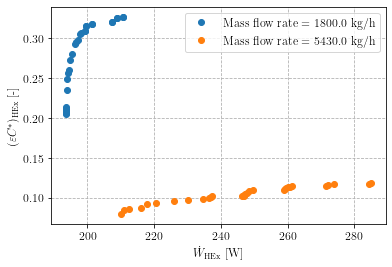

In [61]:
plt.plot(Final_Mass.get_group(mfr[0])['W_p'] + Final_Mass.get_group(mfr[0])['W_o'],Final_Mass.get_group(mfr[0])['ECr'],'o',label = 'Mass flow rate = ' + str(np.round(mfr[0]*3600)) + ' kg/h')
plt.plot(Final_Mass.get_group(mfr[-1])['W_p'] + Final_Mass.get_group(mfr[-1])['W_o'],Final_Mass.get_group(mfr[-1])['ECr'],'o',label = 'Mass flow rate = ' + str(np.round(mfr[-1]*3600)) + ' kg/h')
plt.legend()
plt.legend()
plt.ylabel(r'$(\varepsilon C^\mathrm{*})_\mathrm{HEx}$ [-]')
plt.xlabel('$\dot{W}_\mathrm{HEx}$ [W]')
plt.grid(linestyle = 'dashed')